## Prepare Datasets

Kita akan memakai dataset dari link: https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view?usp=drive_link. Di dalamnya terdapat "data_preprocessed.tsv".

In [1]:
import pandas as pd
import requests
from io import StringIO

In [2]:
file_link = 'https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view?usp=drive_link'
file_link = 'https://drive.google.com/uc?id=' + file_link.split('/')[-2]

direct_download_link = file_link.replace('open', 'uc')

response = requests.get(direct_download_link)

csv_from_drive = StringIO(response.text)

In [3]:
df = pd.read_csv(csv_from_drive,
                sep='\t',
                names=['text','sentiment'])

In [4]:
df.head(3)

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive


In [5]:
df['sentiment'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: sentiment, dtype: int64

## Text Normalization / Cleansing

In [6]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [7]:
df['text_clean'] = df.text.apply(cleansing)

In [8]:
df.head()

,text,sentiment,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


#### Sort the data and lable based on sentiments

In [9]:
neg = df.loc[df['sentiment'] == 'negative'].text_clean.tolist()
neu = df.loc[df['sentiment'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['sentiment'] == 'positive'].text_clean.tolist()

neg_sentiment = df.loc[df['sentiment'] == 'negative'].sentiment.tolist()
neu_sentiment = df.loc[df['sentiment'] == 'neutral'].sentiment.tolist()
pos_sentiment = df.loc[df['sentiment'] == 'positive'].sentiment.tolist()

In [10]:
total_data = pos + neu + neg
sentiments = pos_sentiment + neu_sentiment + neg_sentiment

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


## Feature Extraction

In [11]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")


tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [12]:
Y = pd.get_dummies(sentiments)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Prepare train & test datasets/Splitting Dataset

In [13]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Training

In [14]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [15]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


880/880 [==============================] - 83s 92ms/step - loss: 0.4564 - accuracy: 0.8215 - val_loss: 0.3214 - val_accuracy: 0.8827
Epoch 2/10
880/880 [==============================] - 81s 92ms/step - loss: 0.1987 - accuracy: 0.9283 - val_loss: 0.3219 - va

## Evaluation

### Confussion Matrix, Accuracy, F1, Recall, Precision

In [16]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 7ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       685
           1       0.85      0.79      0.82       233
           2       0.92      0.92      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.85      0.86      2200
weighted avg       0.88      0.88      0.88      2200



The result shows that the F1 Score for Negative is in 0.84, 0.82 for Neutral, and 0.92 for Positive.
This shows that the model is good enough, but have a weak tendency towards defining 'neural' sentiment

## Cross Validation

In [17]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=10,random_state=42,shuffle=True)

accuracies = []

y = Y

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 7ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       685
           1       0.76      0.77      0.77       233
           2       0.90      0.92      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.83      0.83      0.83      2200
weighted avg       0.86      0.87      0.87      2200

69/69 [==============================] - 1s 9ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       685
           1       0.86      0.74      0.79       233
           2       0.93      0.88      0.90      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200

69/69 [==============================] - 1s 10ms/step
Training ke- 3
              precision    recall

The validation training shows that the model have an average accuracy of 87.5% which is indicates a good model

## Visualization

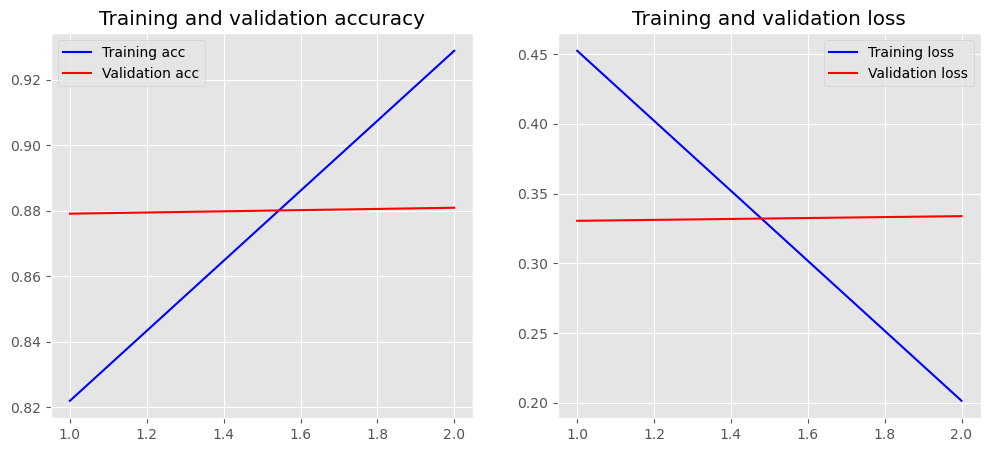

In [18]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

The training model indicates that this can be categorized as underfitting. This can be caused by several points:
1. The training data is small
2. The training process stopped too fast, or the early stopping implementation is not right

In [22]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [35]:
import re 
from keras.models import load_model

input_text = """
terkapar
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 269ms/step
Text:   terkapar 
Sentiment:  positive


In [36]:
# Inside your 'lstm_text_processing' endpoint
prediction = model.predict(guess)
confidence_scores = prediction[0]
predicted_class = np.argmax(prediction[0])
get_sentiment = sentiment[predicted_class]

# Print out predictions and confidence scores
print("Predictions:", dict(zip(sentiment, confidence_scores)))
print("Predicted Sentiment:", get_sentiment)

1/1 [==============================] - 0s 25ms/step
Predictions: {'negative': 0.2859093, 'neutral': 0.07056966, 'positive': 0.64352113}
Predicted Sentiment: positive
